In [1]:
import json
import string
import numpy as np
import scipy.linalg
scipy.linalg.triu = np.triu
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from corpus import corpus
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [2]:
# Custom stopwords (problem-specific list)
stop_words = {"the", "and", "of", "in", "a", "to", "is", "it", "you", "for", 
"on", "with", "this", "that", "are", "as", "be"}

def preprocess(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lowercase
    text = text.lower()
    # Split and filter
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    # Rejoin with spaces
    return ' '.join(filtered_words)

In [3]:
# 1)

# Load data
with open('JEOPARDY_QUESTIONS.json') as f:
    data = json.load(f)
    questions = [item['question'] for item in data[:2000]]


preprocessed_questions = [preprocess(q) for q in questions]

# One-hot encoding
vectorizer = CountVectorizer(binary=True)
one_hot_encoded = vectorizer.fit_transform(preprocessed_questions)

# # Output shape and example
print(f"One-hot encoded matrix shape: {one_hot_encoded.shape}")
print("Example vector:", one_hot_encoded[0].toarray())


# # Calculate cosine similarities
similarity_matrix = cosine_similarity(one_hot_encoded)

# # Find most similar pair (excluding identical ones)
n = similarity_matrix.shape[0]
rows, cols = np.triu_indices(n, k=1)
upper_similarities = similarity_matrix[rows, cols]

mask = upper_similarities < 1.0 - 1e-8
eligible_pairs = upper_similarities[mask]

if eligible_pairs.size == 0:
    print("No eligible pairs found.")
else:
    max_idx = np.argmax(eligible_pairs)
    max_sim = eligible_pairs[max_idx]
    i, j = rows[mask][max_idx], cols[mask][max_idx]
    
    print(f"\nMost Similar Pair (Score: {max_sim:.4f}):")
    print(f"Q1: {questions[i]}")
    print(f"Q2: {questions[j]}")

One-hot encoded matrix shape: (2000, 7746)
Example vector: [[0 0 0 ... 0 0 0]]

Most Similar Pair (Score: 0.6682):
Q1: 'Andy Garcia is a native of this country whose flag is seen here'
Q2: 'This Mediterranean country whose flag is seen here is "The Word"'


In [5]:
# # 2) 

preprocessed_docs = [preprocess(docs) for docs in corpus]

# #TF-IDF calcculation
vectorizer2 = TfidfVectorizer(lowercase=False, stop_words=None)
tfidf_matrix = vectorizer.fit_transform(preprocessed_docs)
feature_names = vectorizer.get_feature_names_out()

 # Extract top 4 keywords per document
keywords_per_doc = []
for i in range(tfidf_matrix.shape[0]):
    scores = tfidf_matrix[i].toarray().flatten()
    top_indices = np.argsort(scores)[::-1][:4]
    keywords = [feature_names[idx] for idx in top_indices]
    keywords_per_doc.append(keywords)

# Print results
for idx, keywords in enumerate(keywords_per_doc):
    print(f"Document {idx+1}: {keywords}")



Document 1: ['wind', 'offer', 'change', 'renewable']
Document 2: ['accelerating', 'forests', 'deforestation', 'protecting']
Document 3: ['efforts', 'essential', 'result', 'marine']
Document 4: ['practices', 'farming', 'permaculture', 'precision']
Document 5: ['crucial', 'architecture', 'planning', 'creating']
Document 6: ['availability', 'innovative', 'ensuring', 'rainwater']
Document 7: ['policies', 'contribute', 'singleuse', 'environmental']
Document 8: ['transition', 'infrastructure', 'cars', 'expansion']
Document 9: ['impacts', 'patterns', 'mitigating', 'events']
Document 10: ['crucial', 'biodiversity', 'habitat', 'wildlife']


In [7]:
# 3)

#word2vec format
glove_path = "glove.6B.300d.txt"  # Ensure this file exists
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

# Convert question to embeddings
def question_to_vectors(question):
    vectors = [glove_model[word] for word in question.split() if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(glove_model.vector_size)

# Process questions
preprocessed_questions2 = [preprocess(q) for q in questions]  # Ensure preprocess() is defined
question_vectors = np.array([question_to_vectors(q) for q in preprocessed_questions2])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(question_vectors)

# Exclude identical questions
np.fill_diagonal(similarity_matrix, 0)

# Find most similar non-identical pair
i, j = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)
max_sim = similarity_matrix[i, j]

print(f"Most Similar Pair (Embedding Score: {max_sim:.4f}):")
print(f"Q1: {questions[i]}")
print(f"Q2: {questions[j]}")

/var/folders/ss/c9374f856hjczbz8kc9hjxzm0000gn/T/ipykernel_56941/2045155951.py:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input, word2vec_output)


Most Similar Pair (Embedding Score: 1.0000):
Q1: '<a href="http://www.j-archive.com/media/1997-11-10_DJ_27.jpg" target="_blank">[video clue]</a>'
Q2: '<a href="http://www.j-archive.com/media/1997-11-10_DJ_28.jpg" target="_blank">[video clue]</a>'


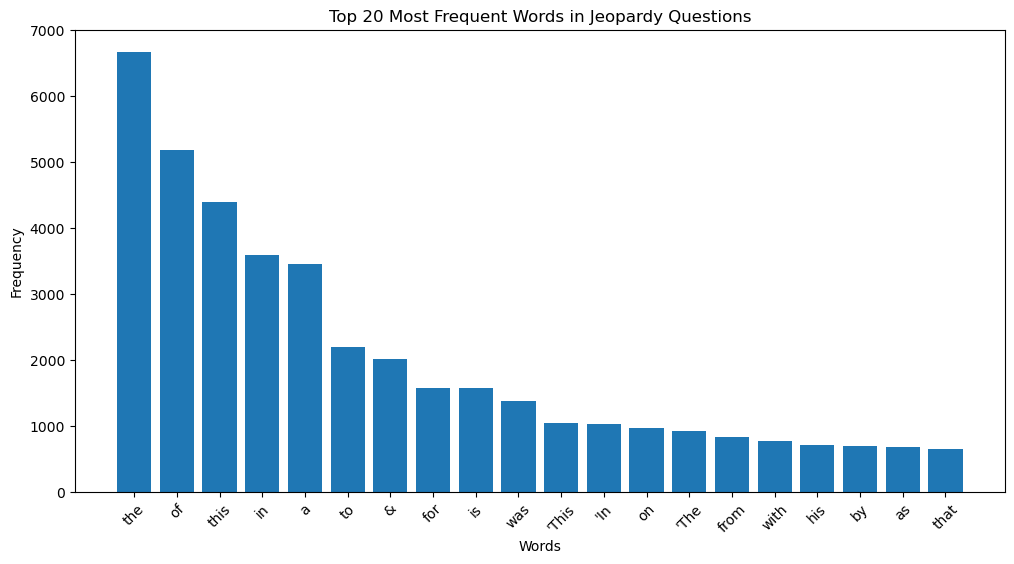

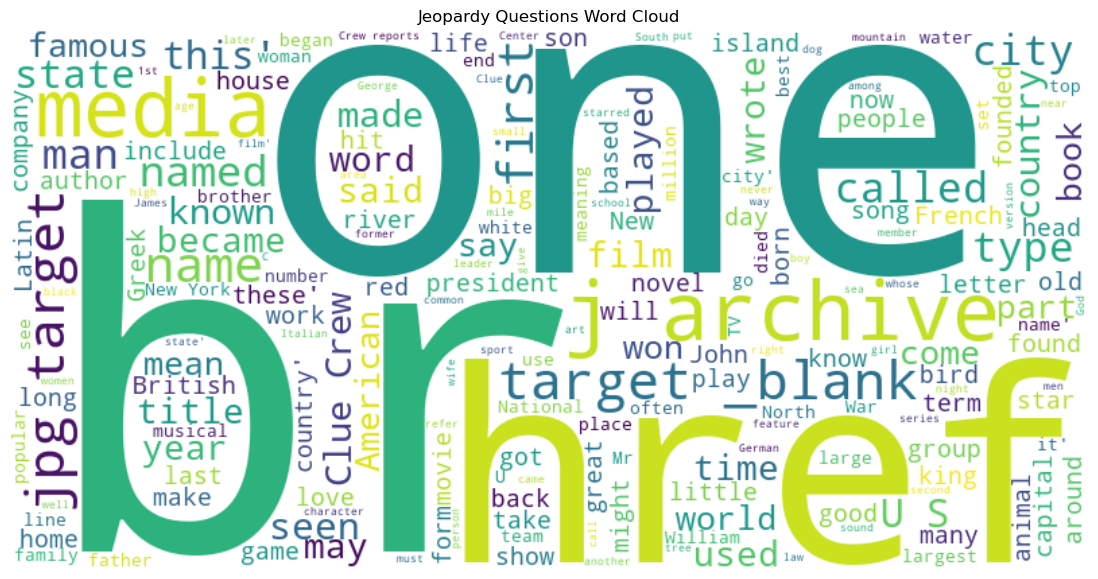

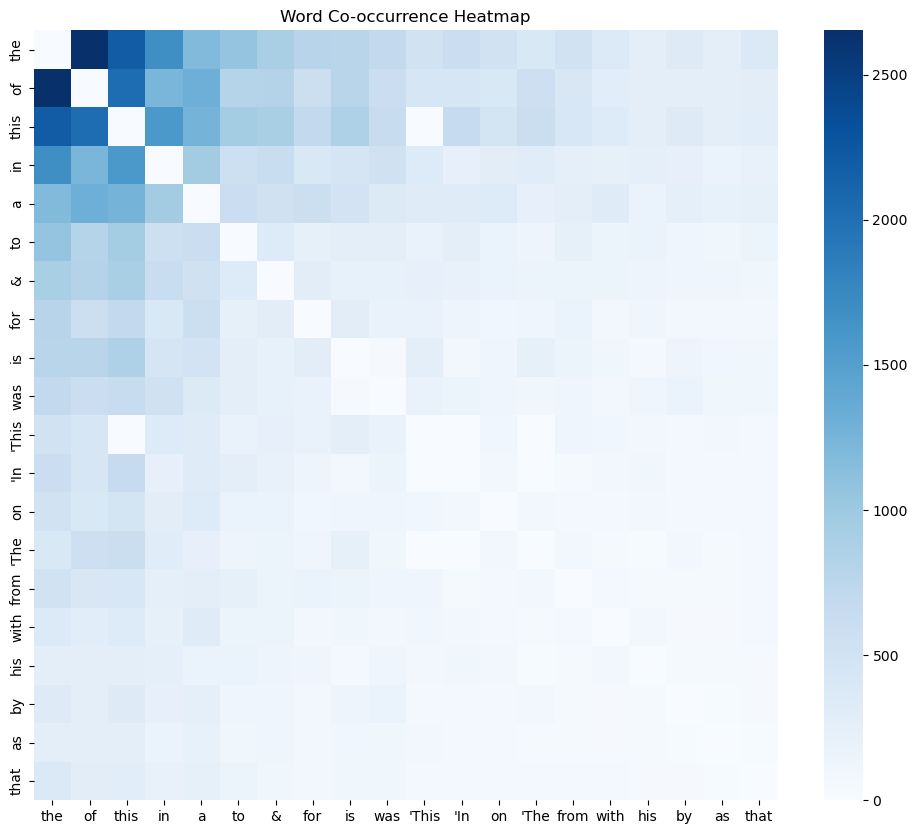

In [8]:
# 4

import nltk
import json 
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
from itertools import combinations


# Load data
with open('JEOPARDY_QUESTIONS.json') as f:
    data = json.load(f)
    questions = [item['question'] for item in data[:10000]]

# 1)

# A)
# Assuming 'questions' is a list of preprocessed questions
all_words = ' '.join(questions).split()

# Count word frequencies
word_freq = Counter(all_words)
most_common = word_freq.most_common(20)

# Plot Bar Chart
words, counts = zip(*most_common)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in Jeopardy Questions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


# B)
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Plot Word Cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Jeopardy Questions Word Cloud')
plt.show()


# C)

# Get unique words
unique_words = [word for word, _ in most_common]
co_occurrence = pd.DataFrame(0, index=unique_words, columns=unique_words)

# Build co-occurrence matrix
for question in questions:
    tokens = set(question.split())
    for word1, word2 in combinations(tokens, 2):
        if word1 in unique_words and word2 in unique_words:
            co_occurrence.at[word1, word2] += 1
            co_occurrence.at[word2, word1] += 1

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, cmap='Blues')
plt.title('Word Co-occurrence Heatmap')
plt.show()

In [9]:
#5


def binary_to_text(file_path):
    with open(file_path, 'r') as file:
        binary_data = file.read().replace("\n", "").strip()  # Read input
    
    # Split into 8-bit chunks
    characters = [binary_data[i:i+8] for i in range(0, len(binary_data), 8)]
    
    # Convert binary to ASCII
    text = ''.join([chr(int(char, 2)) for char in characters])
    
    print("Decoded Text:", text)


#test:
binary_to_text("binary.txt")

Decoded Text: Hello World


In [10]:
#BONUS


def logic_circuit(A, B, C):
    # Compute the individual terms
    term1 = A and B
    term2 = (not A) and (not B)
    term3 = A and B and C

    # Final output  OR logic
    output = term1 or term2 or term3
    return int(output)  # Convert boolean (0 or 1)

# Test

# Given cases
test_cases = [
    (0, 0, 0),
    (0, 0, 1),
    (0, 1, 0),
    (0, 1, 1),
    (1, 0, 0),
    (1, 0, 1),
    (1, 1, 0),
    (1, 1, 1)
]

# Run test cases
print("A B C | Output")
print("---------------")
for A, B, C in test_cases:
    print(A, B, C, "|", logic_circuit(A, B, C))


A B C | Output
---------------
0 0 0 | 1
0 0 1 | 1
0 1 0 | 0
0 1 1 | 0
1 0 0 | 0
1 0 1 | 0
1 1 0 | 1
1 1 1 | 1
